In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches
from matplotlib import cm

Bild `image_080318.jpg` aus diesem Verzeichnis laden und die Höhe bzw. Breite auslesen.

In [2]:
image_url = 'image_150318.jpg'
image = plt.imread(image_url)[:,:,0]

height = image.shape[0]
width = image.shape[1]

<IPython.core.display.Javascript object>


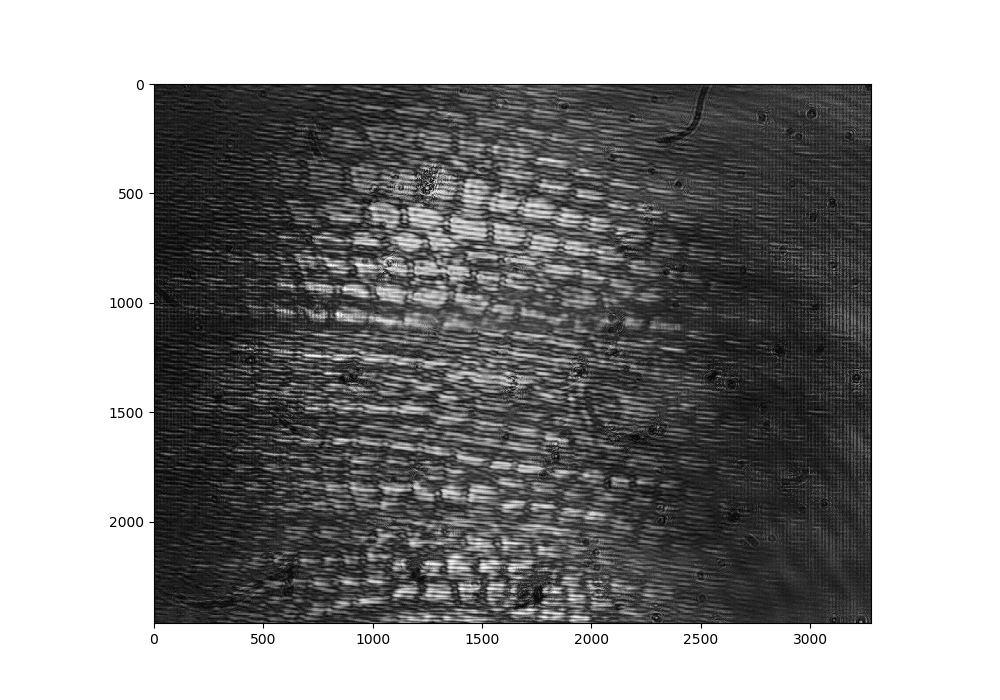

In [3]:
plt.figure("Red channel", figsize=(10,7))
plt.imshow(image, cmap='gray')
plt.show()

## Berechnung des Phasenwinkels
mithilfe der Position des Satelliten (`rect_center_x`, `rect_center_y`).
Anpassung der Parameter evtl. nötig.

In [4]:
rect_center_x = 1619
#rect_center_x = 600

rect_center_y = 794
#rect_center_y = 200

rect_center_radius = 80


fourier = np.fft.fftshift(np.fft.fft2(image))
magnitude_spectrum = np.log(np.abs(fourier+1e-9))

cropped_fourier = np.zeros([height, width], dtype=complex)
satellite = fourier[rect_center_y - rect_center_radius:rect_center_y + rect_center_radius,
            rect_center_x - rect_center_radius:rect_center_x + rect_center_radius]
cropped_fourier[height//2 - rect_center_radius:height//2 + rect_center_radius,
                width//2 - rect_center_radius:width//2 + rect_center_radius] = satellite
phaseangle = np.angle(np.fft.ifft2(np.fft.fftshift(cropped_fourier)))

## Phase unwrap
Dieser Schritt kann je nach Rechenleistung einige Sekunden beanspruchen

In [5]:
x2 = np.arange(-height, height)
y2 = np.arange(-width, width)
x2 = x2**2
y2 = y2**2
x2 = np.roll(x2, height)
y2 = np.roll(y2, width)
r2s = np.add.outer(x2, y2)
r2s = r2s.astype(np.float32)
r2s += 1e-10 # bitte keine Null
mirrored = np.zeros([height*2, width*2])
print(mirrored.shape, height, width)
print(phaseangle.shape)
mirrored[:height, :width] = phaseangle
mirrored[height:, :width] = phaseangle[::-1,:]
mirrored[height:, width:] = phaseangle[::-1, ::-1]
mirrored[:height, width:] = phaseangle[:, ::-1]
holo_cos = np.cos(mirrored)
holo_sin = np.sin(mirrored)

dt = np.fft.fft2
idt = np.fft.ifft2

phi_prime = r2s**-1.0*dt(holo_cos*idt(r2s*dt(holo_sin)) - holo_sin*idt(r2s*dt(holo_cos)))
phi_prime = idt(phi_prime)

phi_ = phi_prime.real[:height, :width]
unwrapped_phase = (phaseangle + 2*np.pi*np.round((phi_ - phaseangle) / 2 / np.pi))

(4928, 6560) 2464 3280
(2464, 3280)


<IPython.core.display.Javascript object>


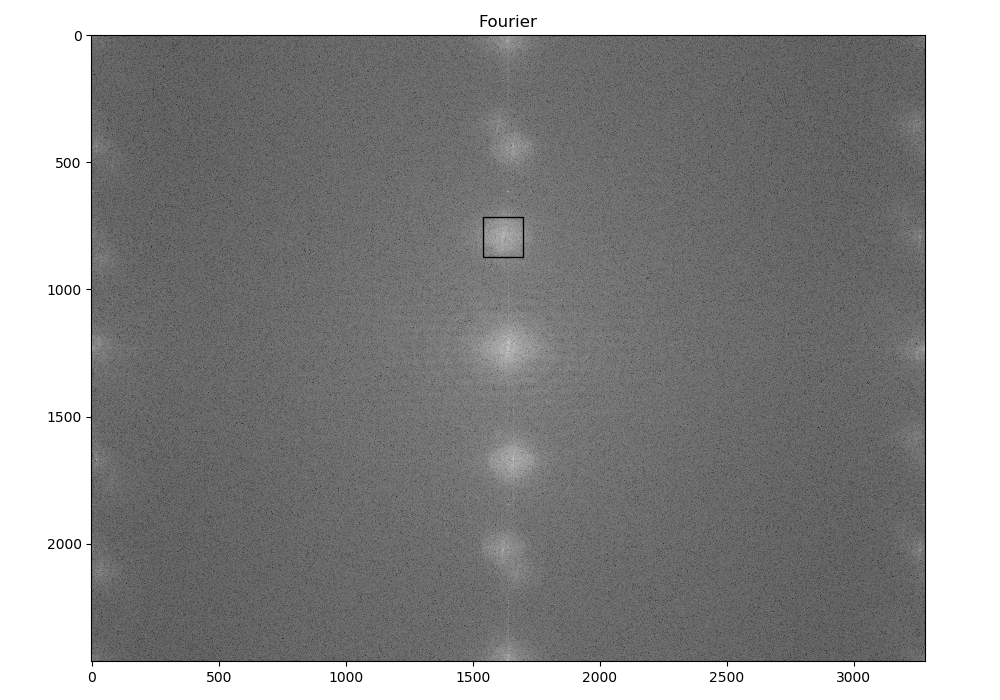

<IPython.core.display.Javascript object>


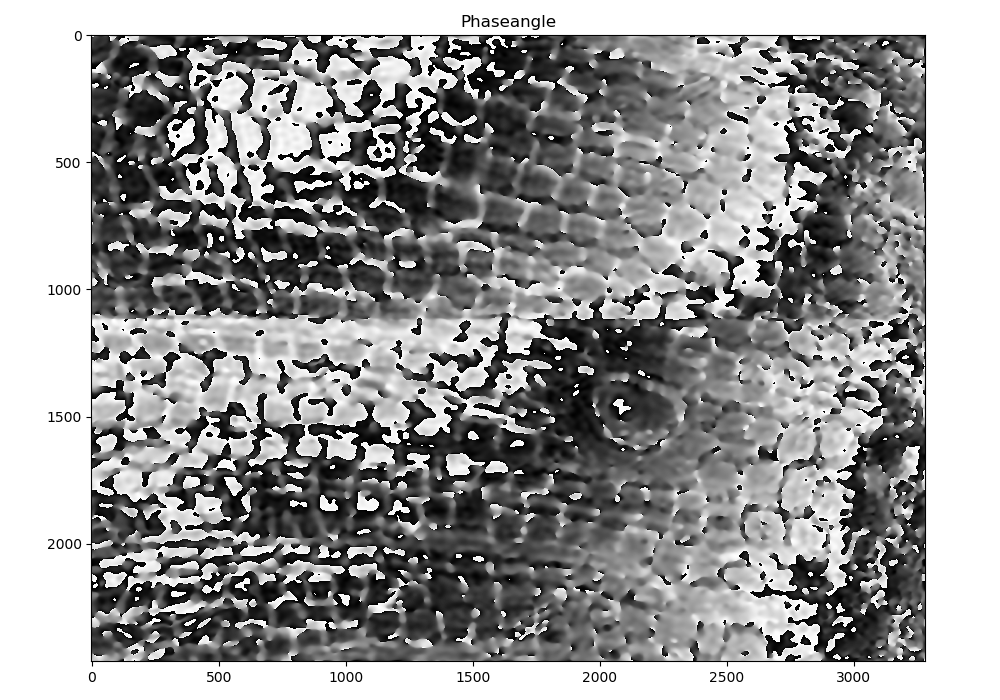

<IPython.core.display.Javascript object>


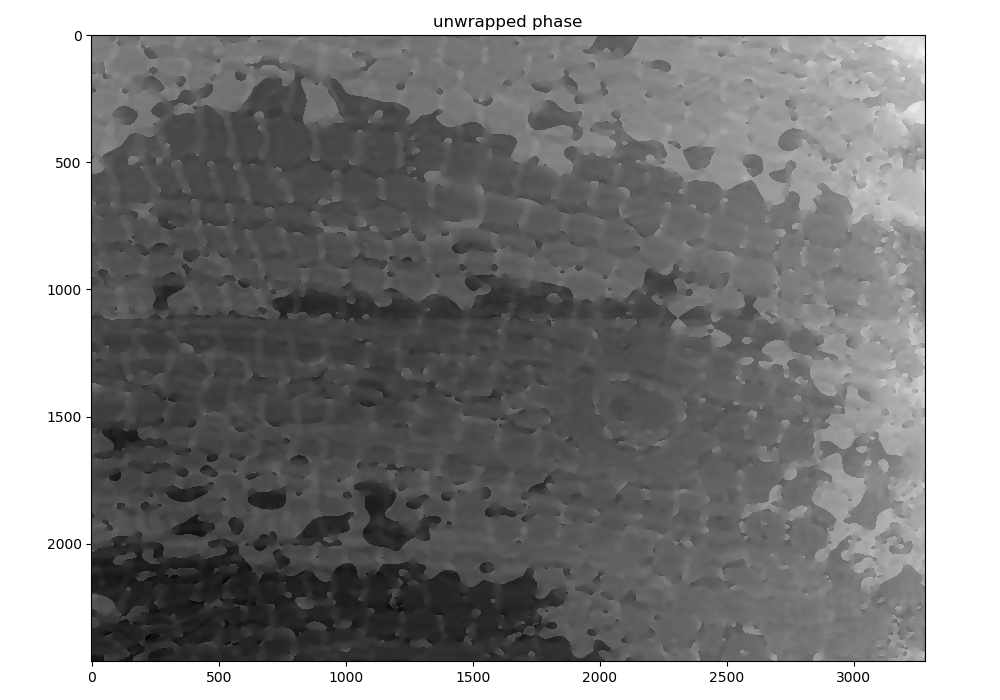

In [6]:
fig1 = plt.figure(figsize=(10, 7))
ax1 = plt.subplot(111)
plt.title("Fourier")
plt.imshow(magnitude_spectrum, cmap='gray')
fig1.tight_layout()

fig2 = plt.figure(figsize=(10, 7))
plt.title("Phaseangle")
plt.imshow(phaseangle, cmap='gray')
fig2.tight_layout()

fig3 = plt.figure(figsize=(10, 7))
plt.title("unwrapped phase")
plt.imshow(unwrapped_phase, cmap='gray')
fig3.tight_layout()
plt.show()

satellite_patch = matplotlib.patches.Rectangle((rect_center_x - rect_center_radius, rect_center_y - rect_center_radius),
                                              rect_center_radius*2, rect_center_radius*2)
satellite_patch.fill = False

ax1.add_patch(satellite_patch)

## Einfache 3D-Anzeige der rekonstruierten Phase

`decimation` dient zur Verringerung der Datenwerte, da sehr große Graphen den Webbrowser überlasten können. Der Wert `1` sorgt dafür, dass jeder Wert weitergegeben wird, bei `2` jeder zweite usw. Es gilt zu beachten dass nur Werte, die ein gerader Teiler von Breite sowie Höhe des Bildes sind, gewählt werden können.

<IPython.core.display.Javascript object>


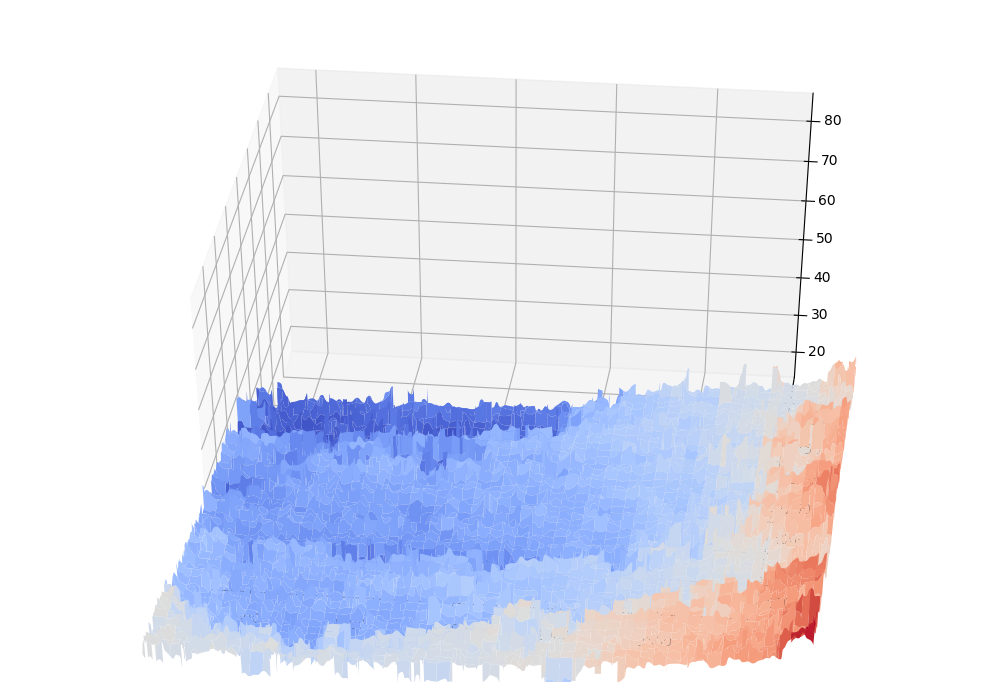

/usr/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [8]:
from mpl_toolkits.mplot3d import Axes3D

decimation = 1

x = np.arange(0, width // decimation)
y = np.arange(0, height // decimation)
X,Y = np.meshgrid(x,y)
Z = unwrapped_phase[::decimation, ::decimation]

fig4 = plt.figure(figsize=(10,7))
plt.title("reconstructed phase 3D")
ax = fig4.add_subplot(111, projection='3d')
ax.set_zlim3d(0, 100)
ax.plot_surface(X, Y, Z, cmap='coolwarm')
fig4.tight_layout()
plt.show()